# C4021 - Group 2.4
## Project
### Dataset
Titanic passenger survival

## Data Loading & Preprocessing

### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### Load Titanic dataset
https://www.kaggle.com/c/titanic/data

In [2]:
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')

train_data.info()
train_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",female,26.0,0,0,19877,78.8500,NaN,S
561,562,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C
583,584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C


## Data Exploration 

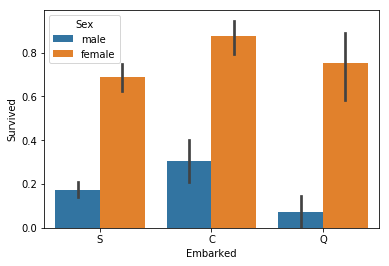

In [3]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train_data);

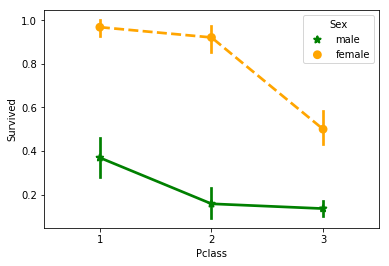

In [4]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_data,
              palette={"male": "green", "female": "orange"},
              markers=["*", "o"], linestyles=["-", "--"]);

## Feature Engineering

In [5]:
def prepare_features(data):
    # Age
    data.Age = data.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 20, 25, 40, 65, 120)
    categories = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    age_groups = pd.cut(data.Age, bins, labels=categories)
    data.Age = age_groups
    
    # TODO: categorise fares, split name?, cabin numbers?
    data.Fare = data.Fare.fillna(-0.5)
    
    # TODO: Convert Pclass to Social Class
    
    # Drop columns
    unwanted_cols = ['Embarked', 'Ticket', 'Name', 'Cabin']
    data.drop(unwanted_cols, axis=1, inplace= True)

    return data

train_data = prepare_features(train_data)
test_data = prepare_features(test_data)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,male,Young Adult,0,0,7.8292
1,893,3,female,Adult,1,0,7.0000
2,894,2,male,Adult,0,0,9.6875
3,895,3,male,Young Adult,0,0,8.6625
4,896,3,female,Student,1,1,12.2875


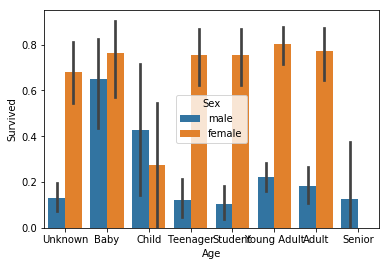

In [6]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=train_data);

### Normalise labels
Use SKLearn's LabelEncoder to convert each unique string value into a number

In [7]:
def encode_features(train, test):
    features = ['Age', 'Sex']
    combined = pd.concat([train[features], test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(combined[feature])
        train[feature] = le.transform(train[feature])
        test[feature] = le.transform(test[feature])
    return train, test
    
train_data, test_data = encode_features(train_data, test_data)
print(train_data.head())
print(test_data.head())

   PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch     Fare
0            1         0       3    1    4      1      0   7.2500
1            2         1       1    0    7      1      0  71.2833
2            3         1       3    0    7      0      0   7.9250
3            4         1       1    0    7      1      0  53.1000
4            5         0       3    1    7      0      0   8.0500
   PassengerId  Pclass  Sex  Age  SibSp  Parch     Fare
0          892       3    1    7      0      0   7.8292
1          893       3    0    0      1      0   7.0000
2          894       2    1    0      0      0   9.6875
3          895       3    1    7      0      0   8.6625
4          896       3    0    4      1      1  12.2875


## Training 
#### Split the Training Data

In [8]:
X_all = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_data['Survived']

test_proportion = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_proportion, random_state=42)

In [9]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
709,3,1,6,1,1,15.2458
439,2,1,7,0,0,10.5000
840,3,1,5,0,0,7.9250
720,2,0,2,0,1,33.0000
39,3,0,5,1,0,11.2417


## Machine Learning
#### Fit, predict and fine tune the algorithms

### Logistic Regression

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
log_reg.score(X_train, y_train)

0.7963483146067416

In [12]:
log_reg.score(X_test, y_test)

0.7877094972067039

In [13]:
lr_predictions = log_reg.predict(X_test)
lr_predictions

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1])

In [14]:
confusion_matrix = confusion_matrix(y_test, lr_predictions)
confusion_matrix

array([[89, 16],
       [22, 52]])

In [15]:
print(accuracy_score(y_test, lr_predictions))

0.7877094972067039


### Linear SVC

In [16]:
svc_clf = svm.LinearSVC()
svc_clf.fit(X_train, y_train)

/Users/gerrykerley/anaconda3/envs/mscai/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
svc_clf.predict(X_test)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1])

In [18]:
svc_clf.score(X_test, y_test)

0.7206703910614525

### K-means Clustering

In [19]:
#TODO:


### Random Forest

In [ ]:
rf_clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 7, 10], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(rf_clf, parameters, scoring=scorer)
grid_search = grid_search.fit(X_train, y_train)

rf_clf = grid_search.best_estimator_

rf_clf.fit(X_train, y_train)

In [ ]:
rf_predictions = rf_clf.predict(X_test)
print(accuracy_score(y_test, rf_predictions))

### Cross Validation

In [ ]:
# TODO: KFold?

### Predict on Test Data

In [ ]:
ids = test_data['PassengerId']

predictions = rf_clf.predict(test_data.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic/titanic-predictions.csv', index = False)
output.head()